## Imports to determine functionality

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup

import collections
from collections import Counter

import wordcloud
from wordcloud import WordCloud, STOPWORDS

from os import path
from re import sub
from re import compile
from email import message_from_file
from glob import glob


import os
from email import message_from_file, policy
from email.parser import BytesParser

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

import missingno as msno
import matplotlib as mpl
%matplotlib inline
import scipy.stats as st
from sklearn import tree, ensemble, linear_model
import string
from sklearn.feature_extraction.text import CountVectorizer

## some NLTK packages that we will need

In [123]:
nltk.download('wordnet') # we will use wordnet lemmatizer
nltk.download('averaged_perceptron_tagger') #to be used for tagger
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [124]:
## mounting google drive for our data.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
os.chdir('/content/drive/MyDrive/')

In [126]:
ham_dir = path.join('data', 'ham')
spam_dir = path.join('data', 'spam')

print('hams:', len(glob(f'{ham_dir}/*')))  # hams: 6952
print('spams:', len(glob(f'{spam_dir}/*')))  # spams: 2399

hams: 6952
spams: 2399


In [127]:
basePath = '/content/drive/MyDrive/data/'
ham_dir = os.path.join(basePath, 'ham')
spam_dir = os.path.join(basePath, 'spam')
print(ham_dir)

print('display number of hams:', len(glob(f'{ham_dir}/*')))
print('display number of spams:', len(glob(f'{spam_dir}/*')))




/content/drive/MyDrive/data/ham
display number of hams: 6952
display number of spams: 2399


## Define Classes

In [128]:
class StandardEmail:
    def __init__(self, subject: str, body: str, origin: str, destination: str):
        self.destination = destination
        self.origin = origin
        self.subject = subject
        self.body = body

    @property
    def clean(self):
        sanitizer = '[^A-Za-z]+'
        clean = sub(sanitizer, ' ', f'{self.subject} {self.body} {self.origin} {self.destination}')
        clean = clean.lower()
        return sub('\s+', ' ', clean)

    @property
    def structured_clean(self):
        sanitizer = '[^A-Za-z]+'
        newsanitizer = compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

        subject = sub(newsanitizer, ' ', f'{self.subject}').lower().lstrip()
        body = sub(sanitizer, ' ', f'{self.body}').lower().lstrip()
        origin = sub(sanitizer, ' ', f'{self.origin}').lower().lstrip()
        destination = sub(sanitizer, ' ', f'{self.destination}').lower().lstrip()

        bsubject = BeautifulSoup(f'{self.subject}', "lxml").text.lower().lstrip()
        bbody = BeautifulSoup(f'{self.body}', "lxml").text.lower().lstrip()
        borigin = BeautifulSoup(f'{self.origin}', "lxml").text.lower().lstrip()
        bdestination = BeautifulSoup(f'{self.destination}', "lxml").text.lower().lstrip()

        # use regular expressions
        # return [sub('\s+', ' ', origin), sub('\s+', ' ', destination), sub('\s+', ' ', subject), sub('\s+', ' ', body)]

        # use beautiful soup to clean https
        return [sub('\s+', ' ', borigin), sub('\s+', ' ', bdestination), sub('\s+', ' ', bsubject), sub('\s+', ' ', bbody)]

    def __str__(self):
        subject = f'subject: {self.subject}'
        body_first_line = self.body.split('\n')[0]
        body = f'body: {body_first_line}...'
        return f'{subject}\n{body}'

    def __repr__(self):
        return self.__str__()

In [129]:
class EmailIterator:
    def __init__(self, directory: str):
        self._files = glob(f'{directory}/*')
        self._pos = 0

    def __iter__(self):
        self._pos = -1
        return self

    def __next__(self):
        if self._pos < len(self._files) - 1:
            self._pos += 1
            return self.parse_email(self._files[self._pos])
        raise StopIteration()

    @staticmethod
    def parse_email(filename: str) -> StandardEmail:
        with open(filename,
                  encoding='utf-8',
                  errors='replace') as fp:
            message = message_from_file(fp)

        subject = None
        for item in message.keys():
            if item == 'Subject':
                subject = message[item]

        if message.is_multipart():
            body = []
            for b in message.get_payload():
                body.append(str(b))
            body = '\n'.join(body)
        else:
            body = message.get_payload()

        return StandardEmail(subject, body, message["From"], message["To"])

## Load emails into memory

In [130]:
ham_emails = EmailIterator('data/ham')
spam_emails = EmailIterator('data/spam')

## Load List of Emails

In [131]:
print("Loading Ham Emails into Memory Please Wait...")
hams = [email.structured_clean for email in ham_emails]
#hams = [[email.destination, email.origin, email.subject, email.body] for email in ham_emails]

Loading Ham Emails into Memory Please Wait...


<ipython-input-128-22e15282c25f>:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bsubject = BeautifulSoup(f'{self.subject}', "lxml").text.lower().lstrip()
<ipython-input-128-22e15282c25f>:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  borigin = BeautifulSoup(f'{self.origin}', "lxml").text.lower().lstrip()
<ipython-input-128-22e15282c25f>:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bbody = BeautifulSoup(f'{self.body}', "lxml").text.lower().lstrip()
<ipython-input-128-22e15282c25f>:26: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, 

In [132]:
print("Loading Spam Emails into memory Please Wait...")
spams = [email.structured_clean for email in spam_emails]

Loading Spam Emails into memory Please Wait...


<ipython-input-128-22e15282c25f>:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bsubject = BeautifulSoup(f'{self.subject}', "lxml").text.lower().lstrip()
<ipython-input-128-22e15282c25f>:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bbody = BeautifulSoup(f'{self.body}', "lxml").text.lower().lstrip()
<ipython-input-128-22e15282c25f>:25: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  bsubject = BeautifulSoup(f'{self.subject}', "lxml").text.lower().lstrip()
<ipython-input-128-22e15282c25f>:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file a

In [133]:
Ham_Subject = []
Ham_Body = []
Ham_From = []
Ham_To = []
for item in hams:
    Ham_From.append(item[0])
    Ham_To.append(item[1])
    Ham_Subject.append(item[2])
    Ham_Body.append(item[3])

Ham_Dictionary = {"From":Ham_From, "To":Ham_To, "Subject":Ham_Subject, "Body":Ham_Body}
Ham_DataFrame = pd.DataFrame(Ham_Dictionary)
Ham_DataFrame.head() #illustrate hamframe in interactive notebook

,From,To,Subject,Body
0,"""paul fries""",,re: [satalk] 2.41/2.50 spamd/spamc problem,"heh. rtfm.. sorry about that. yep, that did th..."
1,"""joseph burke""",spamassassin-talk@example.sourceforge.net,"[satalk] re: spamassassin-talk digest, vol 1 #...",on 9/11/2002 at 10:01 am spamassassin-talk-req...
2,"""malte s. stretz""",spamassassin-talk@example.sourceforge.net,re: [satalk] lotus notes users?,on saturday 07 september 2002 23:22 cet daniel...
3,robin lynn frank,spamassassin-talk@example.sourceforge.net,[satalk] spamd can't find...,"i thought i'd installed razor correctly, but i..."
4,fred inklaar,spamassassin,"re: [satalk] reject, blackhole, or fake no-user",op 12-09-2002 00:35 schreef ellen clary (ellen...


# ▚▚ Exploratory Data Analysis ▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚

In [ ]:
## Subject Character Length

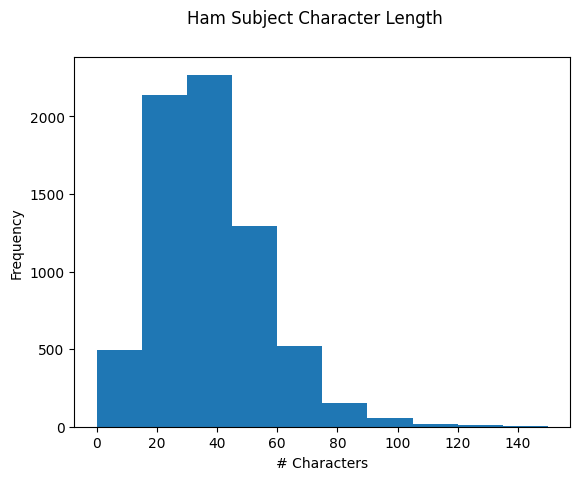

In [32]:
hamhist = Ham_DataFrame["Subject"].str.len().plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Ham Subject Character Length', range=[0, 150])
for ax in hamhist.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

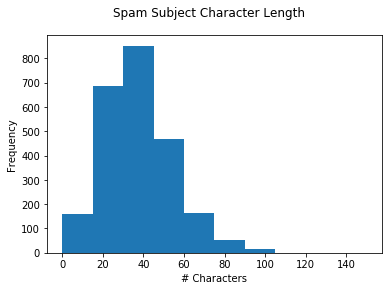

In [ ]:
spamhist = Spam_DataFrame["Subject"].str.len().plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Spam Subject Character Length', range=[0, 150])
for ax in spamhist.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

## Top Non Stopwords in Body Text //Useless

In [210]:
#### Stopwords Function (with modifications) from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [211]:
def plot_top_non_stopwords_barchart(text):

    extrawords = [">", "-", "—", "face", "nbsp","arial","center","align", "http", "com", "td", "width", "www", "font", "height", "src", "img", "gif", "href", "border", "table", "size", "chart", "bgcolor", "color", "cnet"]

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(extrawords)
    stop=set(stopwords)


    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)

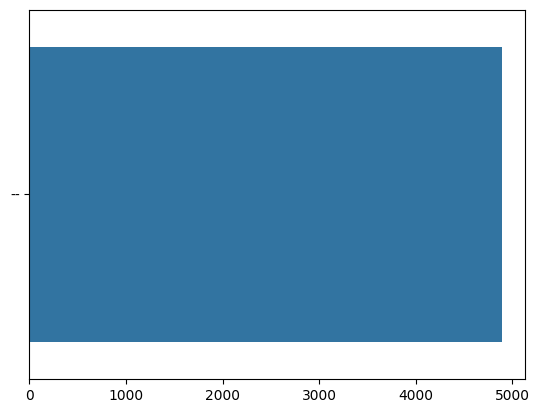

In [212]:
plot_top_non_stopwords_barchart(Ham_DataFrame['Body'])

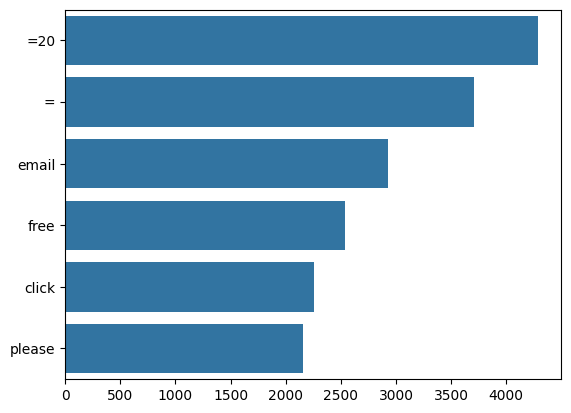

In [213]:
plot_top_non_stopwords_barchart(Spam_DataFrame['Body'])

## Word Length (Average)

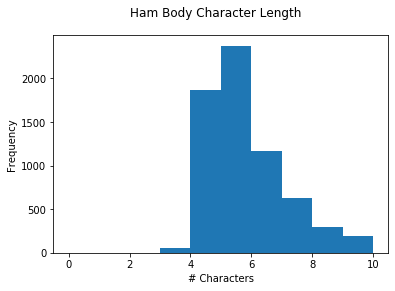

In [ ]:
hwordlen = Ham_DataFrame["Body"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Ham Body Character Length', range=[0, 10])
for ax in hwordlen.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


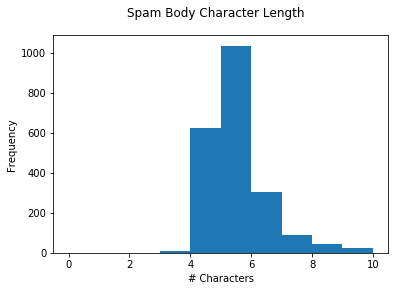

In [ ]:
swordlen = Spam_DataFrame["Body"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Spam Body Character Length', range=[0, 10])
for ax in swordlen.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")


## Word Clouds

In [ ]:
#### word clouds funcntion (with modifications) from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [ ]:
def plot_wordcloud(text):

    extrawords = [">", "-", "—", "face", "nbsp","arial","center","align", "http", "com", "td", "width", "www", "font", "height", "src", "img", "gif", "href", "border", "table", "size", "chart", "bgcolor", "color", "cnet"]
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(extrawords)
    stop=set(stopwords)

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()



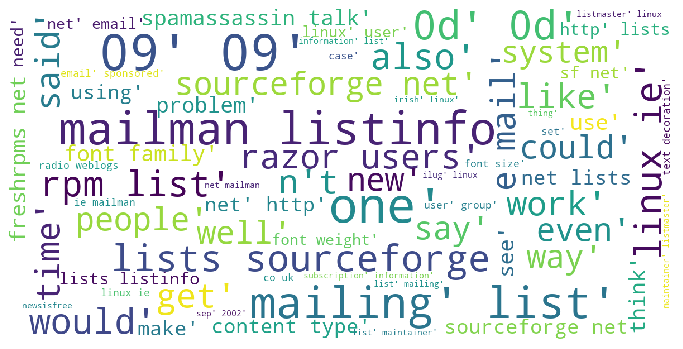

In [ ]:
plot_wordcloud(Ham_DataFrame["Body"])

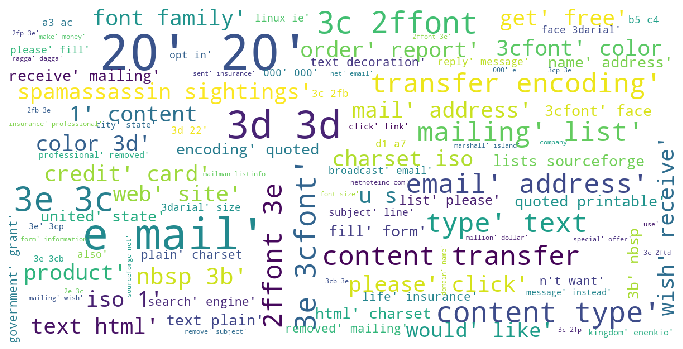

In [ ]:
plot_wordcloud(Spam_DataFrame["Body"])

## Top Bigrams in Body Text //Useless

In [ ]:
#### Top Bigrams Function from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

[Text(0.5, 1.0, 'Bigram Frequencey (Ham)')]

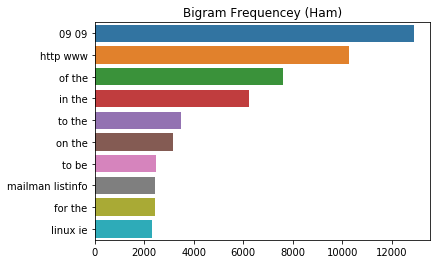

In [ ]:
top_n_bigrams = get_top_ngram(Ham_DataFrame["Body"], 2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Bigram Frequencey (Ham)')


[Text(0.5, 1.0, 'Bigram Frequencey (Spam)')]

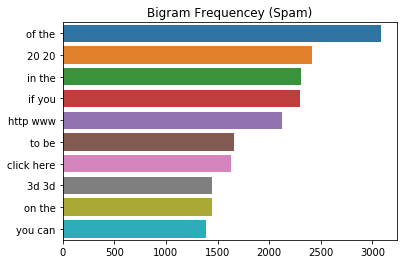

In [ ]:
top_n_bigrams = get_top_ngram(Spam_DataFrame["Body"], 2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Bigram Frequencey (Spam)')

# ▚▚ Feature Extraction ▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚

## Adding label columns as intrengers for Ham so it can be used in Machine learning algos (encoding)

In [134]:
Ham_DataFrame['label']=1

In [135]:
Ham_DataFrame.head(5)

,From,To,Subject,Body,label
0,"""paul fries""",,re: [satalk] 2.41/2.50 spamd/spamc problem,"heh. rtfm.. sorry about that. yep, that did th...",1
1,"""joseph burke""",spamassassin-talk@example.sourceforge.net,"[satalk] re: spamassassin-talk digest, vol 1 #...",on 9/11/2002 at 10:01 am spamassassin-talk-req...,1
2,"""malte s. stretz""",spamassassin-talk@example.sourceforge.net,re: [satalk] lotus notes users?,on saturday 07 september 2002 23:22 cet daniel...,1
3,robin lynn frank,spamassassin-talk@example.sourceforge.net,[satalk] spamd can't find...,"i thought i'd installed razor correctly, but i...",1
4,fred inklaar,spamassassin,"re: [satalk] reject, blackhole, or fake no-user",op 12-09-2002 00:35 schreef ellen clary (ellen...,1


## Dropping duplicate body values

In [136]:
Ham_DataFrame.shape

(6952, 5)

In [137]:
Ham_data_no_duplicates = Ham_DataFrame.drop_duplicates('Body', keep='last')

In [138]:
Ham_data_no_duplicates.shape

(4307, 5)

## Working on Spam

In [139]:
Spam_Subject = []
Spam_Body = []
Spam_From = []
Spam_To = []
for item in spams:
    Spam_From.append(item[0])
    Spam_To.append(item[1])
    Spam_Subject.append(item[2])
    Spam_Body.append(item[3])

Spam_Dictionary = {"From":Spam_From, "To":Spam_To, "Subject":Spam_Subject, "Body":Spam_Body}
Spam_DataFrame = pd.DataFrame(Spam_Dictionary)
Spam_DataFrame.head() #illustrate spamframe in interactive notebook

,From,To,Subject,Body
0,your can,users@mydemaildb.com,get one million emails sent free for your company,do you have a product or service to offer? wou...
1,jane lowery,undisclosed.recipents@locust.minder.net,"bigger, fuller breasts naturally in just weeks...",for women ages 13 to 60 plus.... as seen on tv...
2,,website@netnoteinc.com,adv: search engine placement,to remove see below. i work with a company tha...
3,"""new product showcase""","joey0248@aol.com, virwil1@aol.com",new version 7: uncover the truth about anyone!,============================================= ...
4,cheapdentists8715@flashmail.com,", ,",great health benefits,save up to 80 save up to = 80% on dental servi...


## Adding label columns as intrengers for Spam so it can be used in Machine learning algos (encoding)

In [140]:
Spam_DataFrame['label']=0

In [141]:
Spam_DataFrame.head(5)

,From,To,Subject,Body,label
0,your can,users@mydemaildb.com,get one million emails sent free for your company,do you have a product or service to offer? wou...,0
1,jane lowery,undisclosed.recipents@locust.minder.net,"bigger, fuller breasts naturally in just weeks...",for women ages 13 to 60 plus.... as seen on tv...,0
2,,website@netnoteinc.com,adv: search engine placement,to remove see below. i work with a company tha...,0
3,"""new product showcase""","joey0248@aol.com, virwil1@aol.com",new version 7: uncover the truth about anyone!,============================================= ...,0
4,cheapdentists8715@flashmail.com,", ,",great health benefits,save up to 80 save up to = 80% on dental servi...,0


## dropping duplicate values

In [142]:
Spam_DataFrame.shape

(2399, 5)

In [143]:
data_no_duplicates = Spam_DataFrame.drop_duplicates('Body', keep='last')

In [144]:
data_no_duplicates.shape

(1700, 5)

## adding both data frames of Ham and Spam to get them ready for text processing and feeding to model

In [145]:
result_df = pd.concat([Ham_data_no_duplicates, data_no_duplicates], ignore_index=True)

In [146]:
result_df.head(5)

,From,To,Subject,Body,label
0,ian white,vince puzzella,re: [satalk] badly formatted spam report in ht...,"on wed, 11 sep 2002, vince puzzella wrote: > e...",1
1,yyyy@example.com (justin mason),craig hughes,re: [satalk] re: fully-public corpus of mail a...,craig hughes said: > > - all headers are repro...,1
2,"""postmaster@jpci.net""","""spamassassin-talk-admin@example.sourceforge.n...",failed mail: banned or potentially offensive m...,"content-type: text/plain; charset=""us-ascii"" c...",1
3,"""fox""",,[razor-users] preproc erasing message,the following razor debugging sequence show my...,1
4,none,none,none,mv 00001.7c53336b37003a9286aba55d2945844c 0000...,1


In [147]:
result_df.tail(5)

,From,To,Subject,Body,label
6002,"""peter""",,ruin anyone anywhere anything,i have been receiving emails saying that i'm c...,0
6003,"""industry forum hosted by cpi, llc""",zzzzason@cpan.org,industry forum #136,"content-type: text/html;charset=""iso-8859-1"" c...",0
6004,"""the financial news""",fork@spamassassin.taint.org,production mini-plants in mobile containers. c...,"content-type: text/plain; charset=""iso-8859-1""...",0
6005,webmaster_r4623@yahoo.com,wldflo3669@earthlink.net,discreet penis enlargement 4623,4623,0
6006,"""signature financial""",,6% avg guaranteed for 5 years,"content-type: text/plain; charset=""windows-125...",0


In [148]:
result_df.shape

(6007, 5)

## Adding an additinal column for the lenghth of the body this will serve as feature in our models

In [149]:
result_df['text-length'] = result_df['Body'].str.len()
result_df.head(5)

,From,To,Subject,Body,label,text-length
0,ian white,vince puzzella,re: [satalk] badly formatted spam report in ht...,"on wed, 11 sep 2002, vince puzzella wrote: > e...",1,1340
1,yyyy@example.com (justin mason),craig hughes,re: [satalk] re: fully-public corpus of mail a...,craig hughes said: > > - all headers are repro...,1,794
2,"""postmaster@jpci.net""","""spamassassin-talk-admin@example.sourceforge.n...",failed mail: banned or potentially offensive m...,"content-type: text/plain; charset=""us-ascii"" c...",1,4977
3,"""fox""",,[razor-users] preproc erasing message,the following razor debugging sequence show my...,1,6319
4,none,none,none,mv 00001.7c53336b37003a9286aba55d2945844c 0000...,1,202500


##  Adding an additinal column for the number of punctuations used this will serve as features in our models

In [150]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [151]:
def count_punctuations(text):
    return sum(1 for char in text if char in string.punctuation)

# Add a new column 'PunctuationCount' containing the number of punctuations in body
result_df['Punctuation_Count'] = result_df['Body'].apply(count_punctuations)



In [152]:
result_df.head(5)

,From,To,Subject,Body,label,text-length,Punctuation_Count
0,ian white,vince puzzella,re: [satalk] badly formatted spam report in ht...,"on wed, 11 sep 2002, vince puzzella wrote: > e...",1,1340,271
1,yyyy@example.com (justin mason),craig hughes,re: [satalk] re: fully-public corpus of mail a...,craig hughes said: > > - all headers are repro...,1,794,169
2,"""postmaster@jpci.net""","""spamassassin-talk-admin@example.sourceforge.n...",failed mail: banned or potentially offensive m...,"content-type: text/plain; charset=""us-ascii"" c...",1,4977,447
3,"""fox""",,[razor-users] preproc erasing message,the following razor debugging sequence show my...,1,6319,727
4,none,none,none,mv 00001.7c53336b37003a9286aba55d2945844c 0000...,1,202500,5000


## examining the data for some anamoly detection

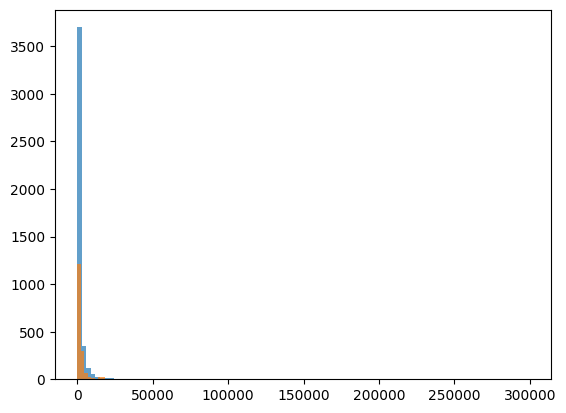

In [153]:
plt.hist(result_df[result_df['label'] == 1]['text-length'], bins = 100, alpha = 0.7, label='Ham')
plt.hist(result_df[result_df['label'] == 0]['text-length'], bins = 100, alpha = 0.7, label='Spam')
plt.show()


In [69]:
## Unusual spike around the number of words lets examine

In [154]:
df_sorted = result_df.sort_values(by='text-length')

In [155]:
df_sorted.tail(5)

,From,To,Subject,Body,label,text-length,Punctuation_Count
4087,"""blo.gs""",zzz@spamassassin.taint.org,updated weblogs from blo.gs,change your settings: http://blo.gs/settings.p...,1,163472,23206
4930,freeidd@dogma.slashnull.org,"hong.kong.commercial@dogma.slashnull.org, hk01...",=?big5?q?=a7k=b6o=b5l=ad=ad=a6=b8=a5=f4=a5=b4=...,content-type: multipart/alternative; boundary=...,0,183957,5581
4,none,none,none,mv 00001.7c53336b37003a9286aba55d2945844c 0000...,1,202500,5000
4978,"""adverting department""","""zzzz@spamassassin.taint.org""",may i have a moment of your time please,content-type: multipart/alternative; boundary=...,0,230685,4481
3474,"""=?iso-2022-jp?b?gyrcmetfbcehp04bkei=?=""","""=?iso-2022-jp?b?jxskqiuijualycemjvklcyu4jwmlx...",=?iso-2022-jp?b?gyrcrnxlxdhsje43b0w+iuolnsvwjt...,"content-type: text/plain; charset=""iso-2022-jp...",1,298977,168982


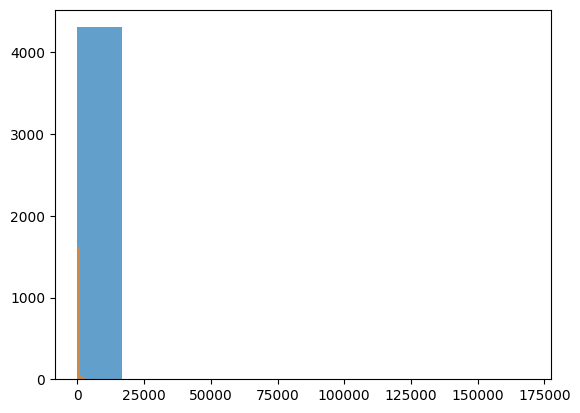

In [156]:
plt.hist(result_df[result_df['label'] == 1]['Punctuation_Count'], bins = 10, alpha = 0.7, label='Ham')
plt.hist(result_df[result_df['label'] == 0]['Punctuation_Count'], bins = 10, alpha = 0.7, label='Spam')
plt.show()

In [157]:
numerical_columns=result_df.select_dtypes(include=[np.number])

<Axes: >

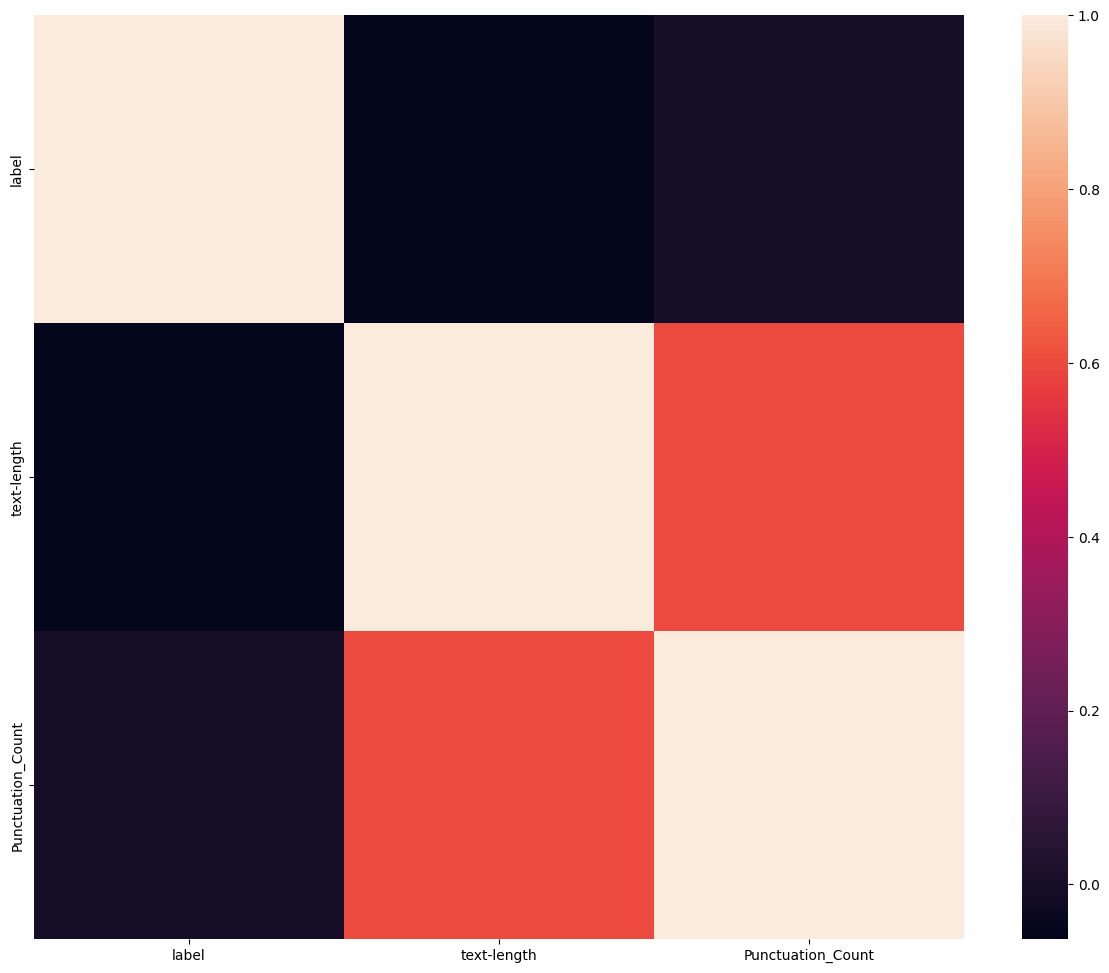

In [158]:
correlation = numerical_columns.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(correlation)

## As we can see there seem to be no relationship between the lengths and the labels

In [159]:
print(correlation['label'].sort_values(ascending = False))

label                1.000000
Punctuation_Count   -0.001065
text-length         -0.063026
Name: label, dtype: float64


## Getting Data ready for our models by doing the below steps



*   Removing Punctuations
*   Tokenization
*   Removing Stopwords
*   Stemming
*   Lemmatization








In [160]:
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [161]:

from nltk.stem.lancaster import LancasterStemmer
import string

stemmer = LancasterStemmer()
wn = nltk.WordNetLemmatizer()

def process(text):

    stopwordList = stopwords.words('english')
    extrawords = [">", "-", "—", "face", "nbsp","arial","center","align", "http", "com", "td", "width", "www", "font", "height", "src", "img", "gif", "href", "border", "table", "size", "chart", "bgcolor", "color", "cnet"]
    stopwordList.extend(extrawords)
    stop=set(stopwordList)

    # Removing Punctuations
    # Check characters to see if they are in punctuation

    text1 = [char for char in text if char not in string.punctuation]
     # Join the characters again to form the string.
    text1 = ''.join(text)

    #Tokenization
    words = nltk.word_tokenize(text1)

    #Removing Stopwords
    words = [t for t in words if t not in stop]

    #Stemming
    words = [stemmer.stem(w.lower()) for w in words]


    #Lemmatization

    words = [wn.lemmatize(w) for w in words]


    return words

In [162]:
result_df['AllText'] = result_df['From'] + ' ' + result_df['To'] + ' ' + result_df['Subject']+ ' ' + result_df['Body']


In [163]:
result_df.head(5)

,From,To,Subject,Body,label,text-length,Punctuation_Count,AllText
0,ian white,vince puzzella,re: [satalk] badly formatted spam report in ht...,"on wed, 11 sep 2002, vince puzzella wrote: > e...",1,1340,271,ian white vince puzzella re: [satalk] badly ...
1,yyyy@example.com (justin mason),craig hughes,re: [satalk] re: fully-public corpus of mail a...,craig hughes said: > > - all headers are repro...,1,794,169,yyyy@example.com (justin mason) craig hughes ...
2,"""postmaster@jpci.net""","""spamassassin-talk-admin@example.sourceforge.n...",failed mail: banned or potentially offensive m...,"content-type: text/plain; charset=""us-ascii"" c...",1,4977,447,"""postmaster@jpci.net"" ""spamassassin-talk-admi..."
3,"""fox""",,[razor-users] preproc erasing message,the following razor debugging sequence show my...,1,6319,727,"""fox"" [razor-users] preproc erasing message ..."
4,none,none,none,mv 00001.7c53336b37003a9286aba55d2945844c 0000...,1,202500,5000,none none none mv 00001.7c53336b37003a9286aba5...


# ▚▚ Modeling ▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚

## Create a pipeline that will use countVectorizer with the function

In [164]:
result_df['AllText'].apply(process)

0       [ian, whit, vint, puzzell, :, [, satalk, ], ba...
1       [yyyy, @, example.com, (, justin, mason, ), cr...
2       [``, postmast, @, jpci.net, '', ``, spamassass...
3       [``, fox, '', [, razor-users, ], preproc, era,...
4       [non, non, non, mv, 00001.7c53336b37003a9286ab...
                              ...                        
6002    [``, pet, '', ruin, anyon, anywh, anyth, recei...
6003    [``, industry, for, host, cpi, ,, llc, '', zzz...
6004    [``, fin, new, '', fork, @, spamassassin.taint...
6005    [webmaster_r4623, @, yahoo.com, wldflo3669, @,...
6006    [``, sign, fin, '', 6, %, avg, guarantee, 5, y...
Name: AllText, Length: 6007, dtype: object

In [165]:
from sklearn.feature_extraction.text import CountVectorizer
transformer = CountVectorizer(analyzer=process).fit(result_df['AllText'])
print(len(transformer.vocabulary_))

100037


## Making BOW

In [166]:
data2 = transformer.transform(result_df['AllText'])

## Exmaple

In [167]:
message3 = result_df['AllText'][2]
print(message3)
bow3 = transformer.transform([message3])
print(bow3)
print(bow3.shape)

"postmaster@jpci.net"  "spamassassin-talk-admin@example.sourceforge.net"  failed mail: banned or potentially offensive material content-type: text/plain; charset="us-ascii" content-transfer-encoding: 7bit content-disposition: inline your message was not delivered to daz@jpci.net this mail message contains banned or potentially offensive text. content-type: message/delivery-status content-transfer-encoding: 7bit content-disposition: inline reporting-mta: dns;buffy.jpci.net final-recipient: rfc822;daz@jpci.net action: failure status: 550 phrase in email not acceptable content-type: message/rfc822 content-transfer-encoding: 7bit content-disposition: inline received: from usw-sf-list1-b.sourceforge.net ([10.3.1.13] helo=usw-sf-list1.sourceforge.net) by usw-sf-list2.sourceforge.net with esmtp (exim 3.31-va-mm2 #1 (debian)) id 17ywhf-0003wq-00; tue, 08 oct 2002 08:28:05 -0700 received: from dsl092-072-213.bos1.dsl.speakeasy.net ([66.92.72.213] helo=blazing.arsecandle.org) by usw-sf-list1.sou

In [168]:
print(transformer.get_feature_names_out()[16])

'-type


In [169]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(data2)
data_tfidf = tfidf_transformer.transform(data2)
print(data_tfidf.shape)

(6007, 100037)


In [170]:
data_tfidf

<6007x100037 sparse matrix of type '<class 'numpy.float64'>'
	with 812247 stored elements in Compressed Sparse Row format>

In [171]:
from sklearn.model_selection import train_test_split

X = result_df.drop(columns=['label'])
msg_train, msg_test, label_train, label_test =  train_test_split(result_df['AllText'], result_df['label'], test_size=0.3, shuffle = True)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))



X = result_df.drop(columns=['label'])
y = result_df.drop(columns=['AllText', 'text-length'])

X_tarin, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)

print(len(X_tarin), len(X_test), len(y_train) , len(y_test))

4204 1803 6007
4805 1202 4805 1202


In [172]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(data_tfidf, result_df['label'])

all_predictions = model.predict(data_tfidf)
print(all_predictions)

[1 1 1 ... 1 0 0]


## Training and Testing a Naive Bayes/MultinomialNB

In [249]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

## Fit the pipeline and then perform prediction

In [250]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7e31f76b3b50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

# Results and Predictions

In [251]:
predictions = pipeline.predict(msg_test)

In [252]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(label_test, predictions))


[[ 152  378]
 [   1 1272]]


In [253]:

tn, fp, fn, tp = confusion_matrix(label_test, predictions).ravel()
tn, fp, fn, tp



(152, 378, 1, 1272)

In [254]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.29      0.45       530
           1       0.77      1.00      0.87      1273

    accuracy                           0.79      1803
   macro avg       0.88      0.64      0.66      1803
weighted avg       0.84      0.79      0.75      1803



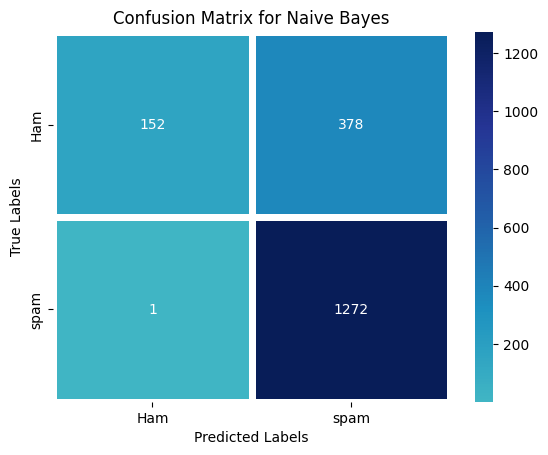

In [255]:
conf_mat = confusion_matrix(label_test, predictions)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for Naive Bayes')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [256]:
NBAccuracy =round(accuracy_score(label_test, predictions),5)

In [257]:
print(NBAccuracy)

0.78979


## Training and Testing a Deep Neural Network

In [240]:
from sklearn.neural_network import MLPClassifier

In [241]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,4), random_state=0, early_stopping=True, verbose=2)),  # train on TF-IDF vectors w/ MLPClassifier classifier with two hidden layers
])

In [242]:
pipeline.fit(msg_train,label_train)

Iteration 1, loss = 0.68461759
Validation score: 0.947743
Iteration 2, loss = 0.57453655
Validation score: 0.957245
Iteration 3, loss = 0.44438465
Validation score: 0.954869
Iteration 4, loss = 0.31576178
Validation score: 0.961995
Iteration 5, loss = 0.20817678
Validation score: 0.976247
Iteration 6, loss = 0.11688623
Validation score: 0.980998
Iteration 7, loss = 0.06832935
Validation score: 0.983373
Iteration 8, loss = 0.04509198
Validation score: 0.980998
Iteration 9, loss = 0.03240930
Validation score: 0.983373
Iteration 10, loss = 0.02469241
Validation score: 0.983373
Iteration 11, loss = 0.01963449
Validation score: 0.983373
Iteration 12, loss = 0.01609625
Validation score: 0.983373
Iteration 13, loss = 0.01354113
Validation score: 0.983373
Iteration 14, loss = 0.01156569
Validation score: 0.983373
Iteration 15, loss = 0.01005906
Validation score: 0.983373
Iteration 16, loss = 0.00887253
Validation score: 0.983373
Iteration 17, loss = 0.00790863
Validation score: 0.983373
Iterat

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7e31f76b3b50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 4),
                               random_state=0, verbose=2))])

In [243]:
predictions = pipeline.predict(msg_test)

In [244]:
print(confusion_matrix(label_test, predictions))

[[ 517   13]
 [  11 1262]]


In [245]:
tn, fp, fn, tp = confusion_matrix(label_test, predictions).ravel()
tn, fp, fn, tp

(517, 13, 11, 1262)

In [246]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       530
           1       0.99      0.99      0.99      1273

    accuracy                           0.99      1803
   macro avg       0.98      0.98      0.98      1803
weighted avg       0.99      0.99      0.99      1803



In [ ]:
conf_mat = confusion_matrix(label_test, predictions)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for Deep Neural Network')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [247]:
DNNAccuracy =round(accuracy_score(label_test, predictions),5)

In [248]:
print(DNNAccuracy)

0.98669


## Support Vector Machine

In [258]:
# Model

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc = SVC(kernel='sigmoid', gamma=1.0)
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', svc),  # train on TF-IDF vectors w/ MLPClassifier classifier with two hidden layers
])



In [259]:
pipeline.fit(msg_train,label_train)


Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7e31f76b3b50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', SVC(gamma=1.0, kernel='sigmoid'))])

In [260]:
predictions = pipeline.predict(msg_test)

In [261]:
print(confusion_matrix(label_test, predictions))

[[ 495   35]
 [  24 1249]]


In [262]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       530
           1       0.97      0.98      0.98      1273

    accuracy                           0.97      1803
   macro avg       0.96      0.96      0.96      1803
weighted avg       0.97      0.97      0.97      1803



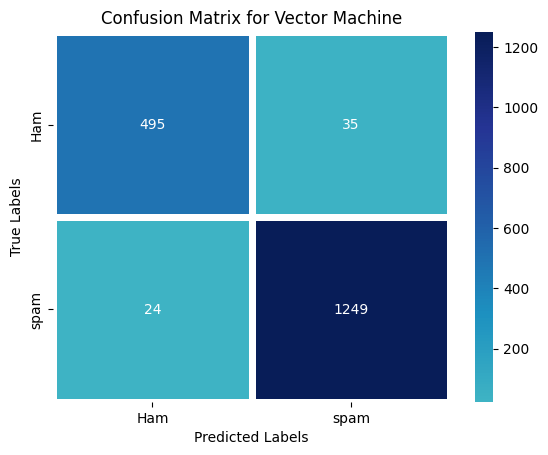

In [263]:
conf_mat = confusion_matrix(label_test, predictions)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for Support Vector Machine')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [238]:
SVMAccuracy =round(accuracy_score(label_test, predictions),5)

In [239]:
print(SVMAccuracy)

0.96728


##Random Forest

In [224]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', rf),  # train on TF-IDF vectors w/ MLPClassifier classifier with two hidden layers
])




In [225]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7e31f76b3b50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=50,
                                        n_jobs=-1))])

In [226]:
predictions = pipeline.predict(msg_test)

In [227]:
print(confusion_matrix(label_test, predictions))

[[ 391  139]
 [   3 1270]]


In [228]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       530
           1       0.90      1.00      0.95      1273

    accuracy                           0.92      1803
   macro avg       0.95      0.87      0.90      1803
weighted avg       0.93      0.92      0.92      1803



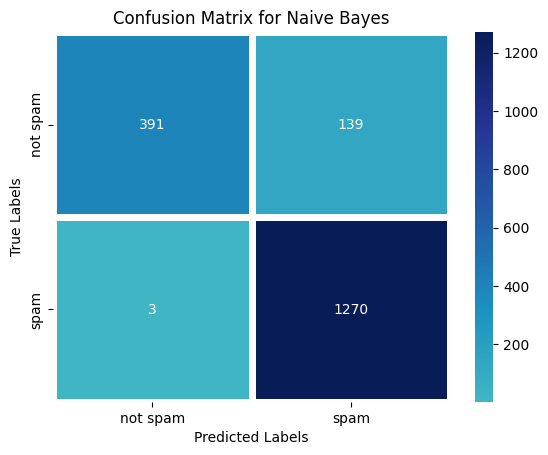

In [229]:
conf_mat = confusion_matrix(label_test, predictions)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for Random Forest')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [230]:
RandomForestAccuracy =round(accuracy_score(label_test, predictions),5)

In [231]:
print(RandomForestAccuracy)

0.92124


## Logistic Regression

In [216]:
from sklearn.linear_model import LinearRegression, LogisticRegression

logisticRegr = LogisticRegression()
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', logisticRegr),  # train on TF-IDF vectors w/ MLPClassifier classifier with two hidden layers
])



In [217]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7e31f76b3b50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

In [218]:
predictions = pipeline.predict(msg_test)

In [219]:
print(confusion_matrix(label_test, predictions))

[[ 485   45]
 [  13 1260]]


In [220]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       530
           1       0.97      0.99      0.98      1273

    accuracy                           0.97      1803
   macro avg       0.97      0.95      0.96      1803
weighted avg       0.97      0.97      0.97      1803



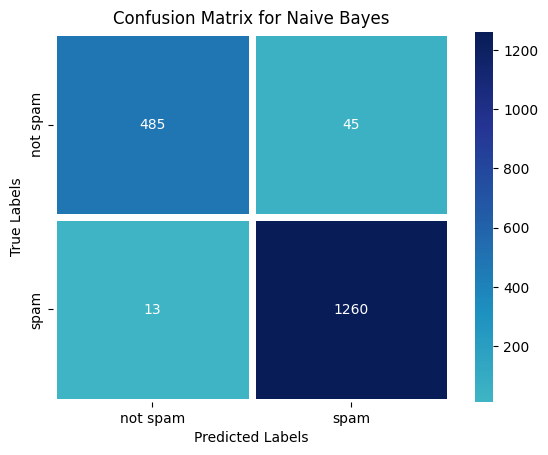

In [221]:
conf_mat = confusion_matrix(label_test, predictions)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for Logistic Regression')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [222]:
LogisticAccuracy =round(accuracy_score(label_test, predictions),5)

In [223]:
print(LogisticAccuracy)

0.96783


## KNearest Neighbors

In [204]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(n_neighbors=149, weights='uniform', algorithm='auto', p=1,metric='euclidean', n_jobs=-1)
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', clf),  # train on TF-IDF vectors w/ MLPClassifier classifier with two hidden layers
])


In [205]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7e31f76b3b50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_jobs=-1,
                                      n_neighbors=149, p=1))])

In [206]:
predictions = pipeline.predict(msg_test)

In [207]:
print(confusion_matrix(label_test, predictions))

[[ 335  195]
 [  54 1219]]


In [208]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.63      0.73       530
           1       0.86      0.96      0.91      1273

    accuracy                           0.86      1803
   macro avg       0.86      0.79      0.82      1803
weighted avg       0.86      0.86      0.85      1803



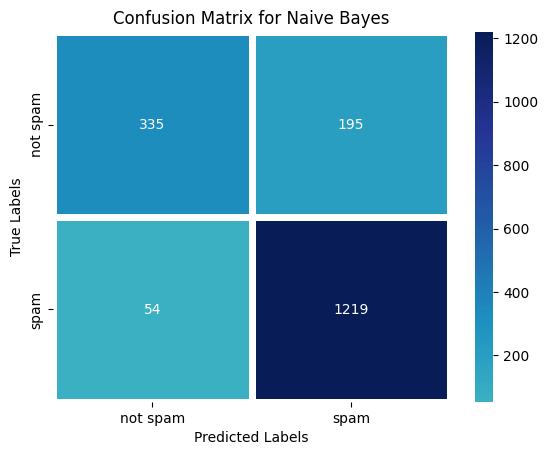

In [209]:
conf_mat = confusion_matrix(label_test, predictions)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for KNearest Neighbors')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [214]:
KNearest =round(accuracy_score(label_test, predictions),5)

In [215]:
print(KNearest)

0.8619


## Would be nice to have a comparison of all models here in a visual format

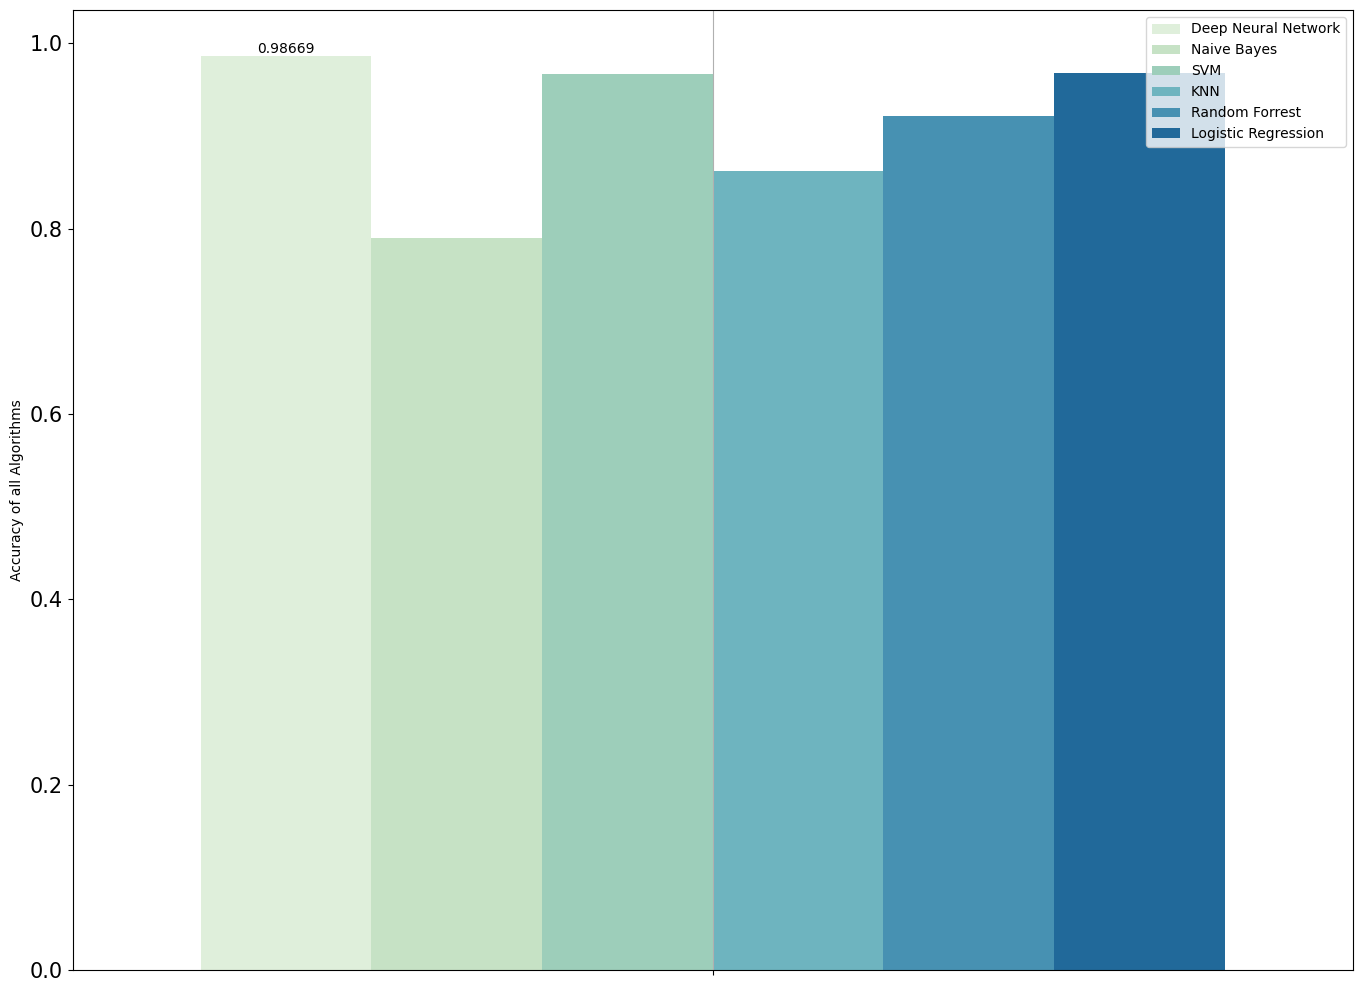

In [273]:
fig = plt.figure()
ax = fig.add_axes([1,1,2,2]);


model = ['Deep Neural Network', 'Naive Bayes', 'SVM', 'KNN', 'Random Forrest', 'Logistic Regression']
accuracies = [DNNAccuracy,NBAccuracy,SVMAccuracy,KNearest,RandomForestAccuracy,LogisticAccuracy]


gr=sns.barplot(hue=model,y=accuracies,palette="GnBu")
ax.set_ylabel("Accuracy of all Algorithms")
ax.tick_params(labelsize=15)
gr.bar_label(gr.containers[0])
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7);
plt.grid()

plt.show();